In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

## PharmacoKinetics

In [18]:
def central_dydt(current_state, params):
    dC_dt = (params["k_dose"]*current_state["dose"]
            + sum(params["k_perif"]*current_state["peripheral"])
            - sum(params["k_perif"]*current_state["central"])
            - params["Cl"]*current_state["central"])
    return dC_dt

def perif_dydt(current_state, params):
    dP_dt = (params["k_perif"]*current_state["central"]
            - params["k_perif"]*current_state["peripheral"])
    return dP_dt

def dose_iv(t):
    return 0
    
def PK_iv_dydt(y, t, param_values, comp=2):
    if comp==1:
        current_state= {'central': y, "peripheral":np.asarray([])}
        current_state["dose"] = dose_iv(t)
        params = {"k_dose" : 1, "Cl" : param_values[1], "k_perif" : np.asarray([])}
        
        dy_dt = central_dydt(current_state, params)
        
    else:
        current_state= {'central': y[0], "peripheral":np.asarray(y[1:])}
        current_state["dose"] = dose_iv(t)
        params= {"k_dose" : 1, "Cl" : param_values[1], "k_perif" : np.asarray(param_values[2:])}

        dC_dt = central_dydt(current_state, params)
        dP_dt = perif_dydt(current_state, params)
        dy_dt = np.insert(dP_dt, [0], [dC_dt])
    
    return dy_dt

def PK_iv_result(dose, num_comp, parameter, times):
    Vol_C = parameter[0] #*1e-03
    y_0 = [dose/Vol_C] +[0]*(num_comp-1)
    results = integrate.odeint(PK_iv_dydt, y_0, times, args=(parameter, num_comp))
    return results

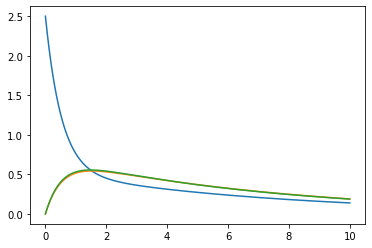

In [19]:
if __name__ == '__main__':
    # Params:
    k_dose = 1
    k_perif = 0.5
    Cl = 0.5
    Vol_C = 2

    dose = 5
    time_span = 10
    times = np.linspace(0,time_span,1000)
    plt.plot(times, PK_iv_result(dose, 3, [Vol_C, Cl, k_perif, k_perif+0.02], times)[:,:])
    plt.show

## Pharmacodynamics

In [20]:
def proliferation_dydt(current_state):
    dProl_dt = (k_prol*current_state["Prol"]
                *(1-E_Drug(current_state["Conc"]))
                *np.power((Circ_0/current_state["Circ"]), gamma)
                - k_tr*current_state["Prol"])
    return dProl_dt
    
def transit_dydt(current_state):
    dT1_dt = k_tr*current_state["Prol"] - k_tr*current_state["T1"]
    dT2_dt = k_tr*current_state["T1"] - k_tr*current_state["T2"]
    dT3_dt = k_tr*current_state["T2"] - k_tr*current_state["T3"]
    return (dT1_dt, dT2_dt, dT3_dt)

def circulation_dydt(current_state):
    dCirc_dt = k_tr*current_state["T3"] - k_circ*current_state["Circ"]
    return dCirc_dt

def PD(y, t):
    variables = ["Prol", "T1", "T2", "T3", "Circ"]
    current_state = dict(zip(variables, y))
    current_state["Conc"] = drug_conc(t)
    # print(current_state)
    dProl_dt = proliferation_dydt(current_state)
    dCirc_dt = circulation_dydt(current_state)
    dT1_dt, dT2_dt, dT3_dt = transit_dydt(current_state)
    return [dProl_dt, dT1_dt, dT2_dt, dT3_dt, dCirc_dt]

In [21]:
def drug_conc(t):
    t_half = 7.5
    k = np.log(2)/t_half
    total_drug = 375
    C_ave = 1/72 * (total_drug - (1/k) * (1+np.exp(-72*k)))
    if t<0:
        conc = 0
    elif t<72:
        conc = C_ave*(1-np.exp(-k*t))
    else:
        conc = C_ave*np.exp(-k*(t-72))
    return conc

def E_Drug(conc):
    return slope*conc
    

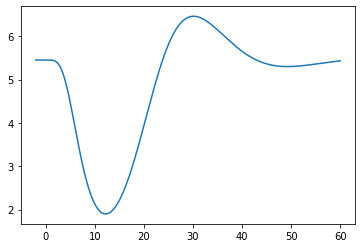

In [22]:
if __name__ == '__main__':
    # Params:
    Circ_0 = 5.45
    MTT = 135
    gamma = 0.174
    slope = 0.126

    n = 3
    k_tr = (n+1)/MTT
    k_prol = k_tr
    k_circ = k_tr


    times = np.linspace(-48,1440,1488)
    y_0 = [Circ_0]*5
    results = integrate.odeint(PD, y_0, times)
    plt.plot(times/24, results[:, 4])
    plt.show